In [4]:
import cv2
import numpy as np
import os
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# ----------------------------
# Load existing dataset (if any)
# ----------------------------
X_file = "X_landmarks.npy"
y_file = "y_labels.npy"


if os.path.exists(X_file) and os.path.exists(y_file):
    X = np.load(X_file, allow_pickle=True).tolist()
    y = np.load(y_file, allow_pickle=True).tolist()
    print("Loaded existing samples:", len(X))
else:
    X = []
    y = []
    print("Starting new dataset")

# ----------------------------
# Label
# ----------------------------
current_label = "up"
print("Initial label:", current_label)

# ----------------------------
# MediaPipe Tasks setup
# ----------------------------
BaseOptions = python.BaseOptions
HandLandmarker = vision.HandLandmarker
HandLandmarkerOptions = vision.HandLandmarkerOptions
VisionRunningMode = vision.RunningMode

options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path="hand_landmarker.task"),
    running_mode=VisionRunningMode.VIDEO,
    num_hands=1
)

cap = cv2.VideoCapture(0)

timestamp = 0

with HandLandmarker.create_from_options(options) as landmarker:

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        mp_image = mp.Image(
            image_format=mp.ImageFormat.SRGB,
            data=rgb
        )

        # timestamp must be increasing (milliseconds)
        timestamp += 33

        result = landmarker.detect_for_video(mp_image, timestamp)

        # Draw landmarks
        if result.hand_landmarks:
            hand = result.hand_landmarks[0]

            h, w, _ = frame.shape
            for lm in hand:
                cx = int(lm.x * w)
                cy = int(lm.y * h)
                cv2.circle(frame, (cx, cy), 4, (0, 255, 0), -1)

        cv2.putText(
            frame,
            f"Label: {current_label}",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 255, 0),
            2
        )

        cv2.imshow("Hand capture (MediaPipe Tasks)", frame)

        key = cv2.waitKey(1) & 0xFF

        # ----------------------------
        # Change label
        # ----------------------------
        if key == ord('1'):
            current_label = "up"
            print("label = up")

        elif key == ord('2'):
            current_label = "down"
            print("label = down")

        elif key == ord('3'):
            current_label = "left"
            print("label = left")

        elif key == ord('4'):
            current_label = "right"
            print("label = right")

        elif key == ord('5'):
            current_label = "takeoff"
            print("label = takeoff")

        elif key == ord('6'):
            current_label = "land"
            print("label = land")

        elif key == ord('7'):
            current_label = "flip"
            print("label = flip")

        # ----------------------------
        # Save one sample
        # ----------------------------
        elif key == ord('s'):
            if result.hand_landmarks:
                hand = result.hand_landmarks[0]

                vec = []
                for lm in hand:
                    vec.extend([lm.x, lm.y, lm.z])

                X.append(vec)
                y.append(current_label)

                print("saved:", current_label, " total =", len(X))
            else:
                print("no hand detected")

        # ----------------------------
        # Quit and save
        # ----------------------------
        elif key == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

np.save(X_file, np.array(X, dtype=object))
np.save(y_file, np.array(y, dtype=object))

print("Saved")
print("X shape:", np.array(X).shape)
print("y shape:", np.array(y).shape)


Loaded existing samples: 331
Initial label: up
Saved
X shape: (331, 63)
y shape: (331,)


In [1]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

# ---------------------------
# Load data
# ---------------------------
X = np.load("X_landmarks.npy", allow_pickle=True)
y = np.load("y_labels.npy", allow_pickle=True)

print("X shape:", X.shape)
print("y shape:", y.shape)

X = X.astype("float32")

# ---------------------------
# Encode labels
# ---------------------------
le = LabelEncoder()
y_enc = le.fit_transform(y)

print("Classes:", le.classes_)

# ---------------------------
# Train / validation split
# ---------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# ---------------------------
# Simple MLP model
# (NOT CNN – landmarks are vectors, not images)
# ---------------------------
model = keras.Sequential([
    layers.Input(shape=(63,)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dense(len(le.classes_), activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# ---------------------------
# Train
# ---------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32
)

# ---------------------------
# Save model + label map
# ---------------------------
model.save("gesture_model.keras")
np.save("label_classes.npy", le.classes_)

print("Model saved as gesture_model.keras")
print("Labels saved as label_classes.npy")


X shape: (331, 63)
y shape: (331,)
Classes: ['down' 'flip' 'land' 'left' 'right' 'takeoff' 'up']


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,903 (66.03 KB)

 Trainable params: 16,903 (66.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1705 - loss: 1.9724 - val_accuracy: 0.2239 - val_loss: 1.8652
Epoch 2/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2424 - loss: 1.8643 - val_accuracy: 0.2388 - val_loss: 1.7864
Epoch 3/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2689 - loss: 1.7870 - val_accuracy: 0.3582 - val_loss: 1.7164
Epoch 4/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3447 - loss: 1.7313 - val_accuracy: 0.3881 - val_loss: 1.6545
Epoch 5/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4015 - loss: 1.6656 - val_accuracy: 0.4328 - val_loss: 1.5755
Epoch 6/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4545 - loss: 1.5710 - val_accuracy: 0.5373 - val_loss: 1.4892
Epoch 7/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4962 - loss: 1.5218 - val_accuracy: 0.5224 - val_loss: 1.4063
Epoch 8/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5152 - loss: 1.4337 - val_accuracy: 0.5821 - val_loss: 1.3082
Epoch 9

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from tensorflow import keras

# ----------------------------
# Load trained model + labels
# ----------------------------
model = keras.models.load_model("gesture_model.keras")
classes = np.load("label_classes.npy", allow_pickle=True)

print("Classes:", classes)

# ----------------------------
# Dummy drone functions
# ----------------------------
def drone_up():      print("DRONE : UP")
def drone_down():    print("DRONE : DOWN")
def drone_left():    print("DRONE : LEFT")
def drone_right():   print("DRONE : RIGHT")
def drone_takeoff(): print("DRONE : TAKEOFF")
def drone_land():    print("DRONE : LAND")
def drone_flip():    print("DRONE : FLIP")

ACTION_MAP = {
    "up": drone_up,
    "down": drone_down,
    "left": drone_left,
    "right": drone_right,
    "takeoff": drone_takeoff,
    "land": drone_land,
    "flip": drone_flip
}

# ----------------------------
# MediaPipe Tasks setup
# ----------------------------
BaseOptions = python.BaseOptions
HandLandmarker = vision.HandLandmarker
HandLandmarkerOptions = vision.HandLandmarkerOptions
VisionRunningMode = vision.RunningMode

options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path="hand_landmarker.task"),
    running_mode=VisionRunningMode.VIDEO,
    num_hands=1
)

cap = cv2.VideoCapture(0)
timestamp = 0

last_gesture = None

with HandLandmarker.create_from_options(options) as landmarker:

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        mp_image = mp.Image(
            image_format=mp.ImageFormat.SRGB,
            data=rgb
        )

        timestamp += 33

        result = landmarker.detect_for_video(mp_image, timestamp)

        predicted = ""

        if result.hand_landmarks:

            hand = result.hand_landmarks[0]

            # 63-D feature vector
            vec = []
            for lm in hand:
                vec.extend([lm.x, lm.y, lm.z])

            x = np.array(vec, dtype=np.float32).reshape(1, 63)

            probs = model.predict(x, verbose=0)[0]
            idx = np.argmax(probs)

            predicted = classes[idx]
            conf = probs[idx]

            # simple confidence gate
            if conf > 0.70:
                if predicted != last_gesture:
                    last_gesture = predicted
                    print("Gesture:", predicted, "conf:", round(float(conf), 2))

                    if predicted in ACTION_MAP:
                        ACTION_MAP[predicted]()

            # draw landmarks
            h, w, _ = frame.shape
            for lm in hand:
                cx = int(lm.x * w)
                cy = int(lm.y * h)
                cv2.circle(frame, (cx, cy), 4, (0,255,0), -1)

        cv2.putText(
            frame,
            f"Gesture: {predicted}",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0,255,0),
            2
        )

        cv2.imshow("Live gesture control", frame)

        if cv2.waitKey(1) & 0xFF == 27:
            break

cap.release()
cv2.destroyAllWindows()


Classes: ['down' 'flip' 'land' 'left' 'right' 'takeoff' 'up']


KeyboardInterrupt: 

: 

Gesture: flip conf: 0.81
DRONE : FLIP
Gesture: left conf: 0.81
DRONE : LEFT
MODE = DRAW
MODE = IDLE
Gesture: land conf: 0.71
DRONE : LAND
MODE = EXECUTE
Drawn points = 144


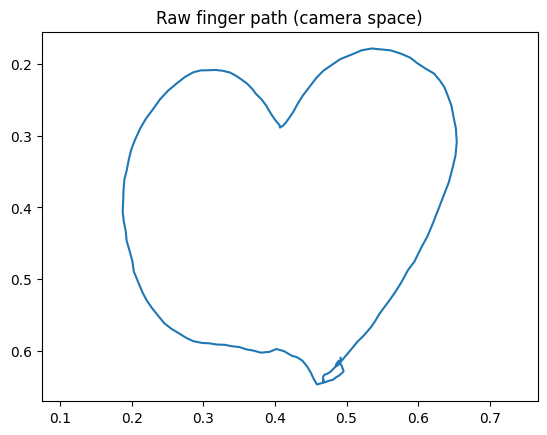

MODE = EXECUTE
Drawn points = 144


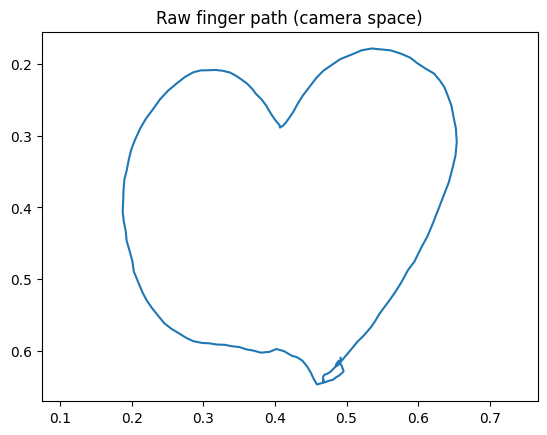

MODE = DRAW
MODE = IDLE
MODE = EXECUTE
Drawn points = 87


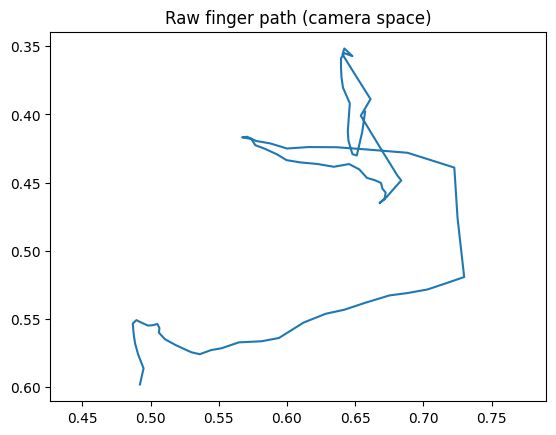

MODE = DRAW
MODE = IDLE
MODE = EXECUTE
Drawn points = 19


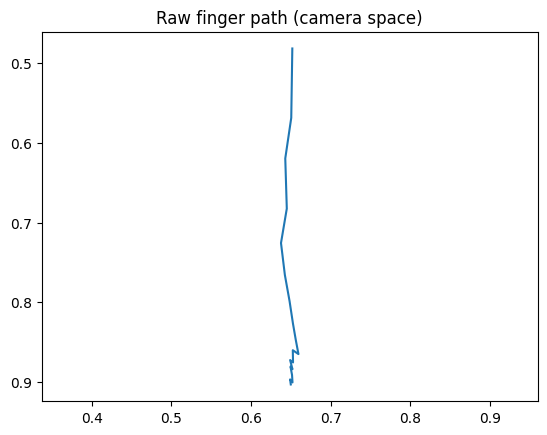

Gesture: left conf: 0.7
DRONE : LEFT
Gesture: takeoff conf: 0.97
DRONE : TAKEOFF
Gesture: up conf: 0.99
DRONE : UP
Gesture: down conf: 0.91
DRONE : DOWN
MODE = DRAW
MODE = IDLE
Gesture: left conf: 0.84
DRONE : LEFT
MODE = DRAW
MODE = IDLE
MODE = DRAW
MODE = IDLE
MODE = EXECUTE
Drawn points = 111


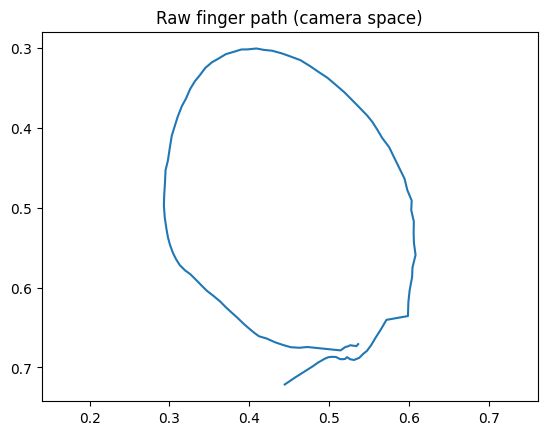

MODE = DRAW
MODE = IDLE
Gesture: up conf: 0.96
DRONE : UP
MODE = DRAW
MODE = IDLE
Gesture: down conf: 0.79
DRONE : DOWN
Gesture: left conf: 0.73
DRONE : LEFT
Gesture: right conf: 0.7
DRONE : RIGHT
Gesture: down conf: 0.74
DRONE : DOWN
Gesture: up conf: 0.78
DRONE : UP
Gesture: land conf: 0.77
DRONE : LAND
Gesture: up conf: 0.97
DRONE : UP
Gesture: left conf: 0.71
DRONE : LEFT
Gesture: land conf: 0.7
DRONE : LAND
Gesture: up conf: 0.74
DRONE : UP
Gesture: left conf: 0.72
DRONE : LEFT
Gesture: land conf: 0.76
DRONE : LAND
Gesture: up conf: 0.84
DRONE : UP
MODE = DRAW
MODE = IDLE
Gesture: left conf: 0.73
DRONE : LEFT
Gesture: land conf: 0.7
DRONE : LAND
Gesture: up conf: 0.75
DRONE : UP
Gesture: land conf: 0.77
DRONE : LAND
MODE = DRAW
MODE = IDLE
MODE = DRAW
MODE = IDLE
MODE = EXECUTE
Drawn points = 540


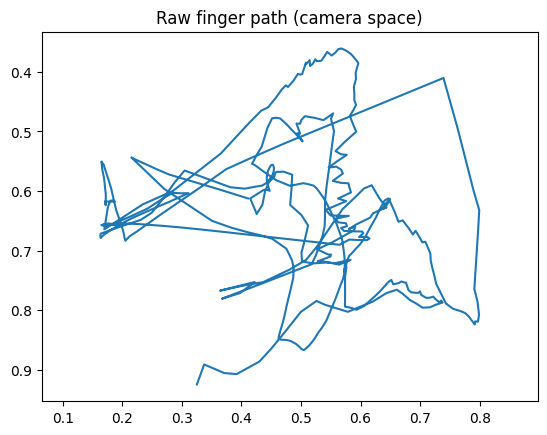

Gesture: land conf: 0.72
DRONE : LAND
MODE = DRAW
MODE = IDLE
MODE = EXECUTE
Drawn points = 633


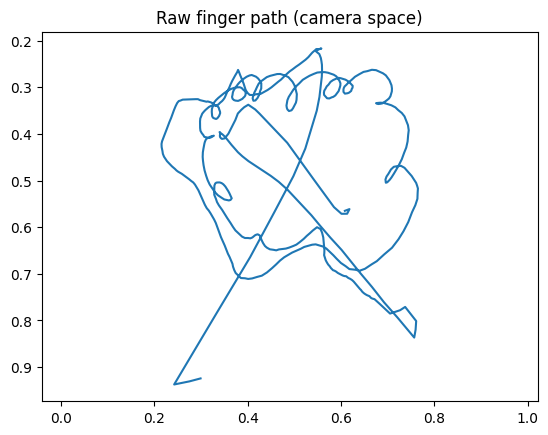

MODE = DRAW
MODE = IDLE
MODE = DRAW
MODE = IDLE
Gesture: land conf: 0.77
DRONE : LAND
MODE = EXECUTE
Drawn points = 179


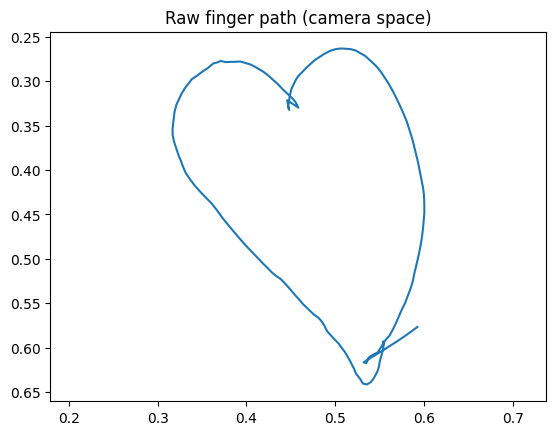

MODE = DRAW
MODE = IDLE
MODE = DRAW
MODE = IDLE
Gesture: up conf: 1.0
DRONE : UP
Gesture: left conf: 0.85
DRONE : LEFT
Gesture: right conf: 0.98
DRONE : RIGHT
Gesture: up conf: 0.99
DRONE : UP
Gesture: left conf: 0.7
DRONE : LEFT
Gesture: up conf: 0.72
DRONE : UP


In [1]:
import cv2
import numpy as np
import time
from collections import deque
import matplotlib.pyplot as plt

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision


from tensorflow import keras
smooth_pt = None
SMOOTH_ALPHA = 0.2   # lower = smoother, higher = more reactive

def init_path_plot():
    fig, ax = plt.subplots()
    ax.set_title("Simulated Drone Path (X–Z plane)")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Z (m)")
    ax.grid(True)
    ax.set_aspect("equal", adjustable="box")
    return fig, ax


drone_traj = []
# -------------------------------------------------
# Load trained gesture model
# -------------------------------------------------

model = keras.models.load_model("gesture_model.keras")
classes = np.load("label_classes.npy", allow_pickle=True)

# -------------------------------------------------
# Dummy drone actions (gesture mode)
# -------------------------------------------------

def drone_up():      print("DRONE : UP")
def drone_down():    print("DRONE : DOWN")
def drone_left():    print("DRONE : LEFT")
def drone_right():   print("DRONE : RIGHT")
def drone_takeoff(): print("DRONE : TAKEOFF")
def drone_land():    print("DRONE : LAND")
def drone_flip():    print("DRONE : FLIP")

ACTION_MAP = {
    "up": drone_up,
    "down": drone_down,
    "left": drone_left,
    "right": drone_right,
    "takeoff": drone_takeoff,
    "land": drone_land,
    "flip": drone_flip
}


# -------------------------------------------------
# MediaPipe Tasks setup
# -------------------------------------------------

BaseOptions = python.BaseOptions
HandLandmarker = vision.HandLandmarker
HandLandmarkerOptions = vision.HandLandmarkerOptions
VisionRunningMode = vision.RunningMode

options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path="hand_landmarker.task"),
    running_mode=VisionRunningMode.VIDEO,
    num_hands=1
)


# -------------------------------------------------
# State machine
# -------------------------------------------------

MODE = "IDLE"     # IDLE | DRAW | EXECUTE 

draw_path = []
last_draw_pt = None

# simulated drone position
# X – left/right
# Y – fixed
# Z – up/down
drone_pos = np.array([0.0, 0.0, 0.0], dtype=np.float32)

EXEC_SCALE = 2.0        # meters per normalized finger motion
EXEC_DT = 0.05         # seconds between steps


# -------------------------------------------------
# Helpers
# -------------------------------------------------
def draw_live_plot(traj_x, traj_z, size=400):
    canvas = np.ones((size, size, 3), dtype=np.uint8) * 255

    if len(traj_x) < 2:
        return canvas

    xs = np.array(traj_x)
    zs = np.array(traj_z)

    # normalize to [0,1]
    xs = (xs - xs.min()) / (xs.max() - xs.min() + 1e-6)
    zs = (zs - zs.min()) / (zs.max() - zs.min() + 1e-6)

    pts = []
    for x, z in zip(xs, zs):
        px = int(x * (size - 20)) + 10
        py = int((1 - z) * (size - 20)) + 10
        pts.append((px, py))

    for i in range(1, len(pts)):
        cv2.line(canvas, pts[i-1], pts[i], (255, 0, 0), 2)

    return canvas

def distance(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)


def build_deltas_2d(path):
   

    pts = np.array(path, dtype=np.float32)

    # center
    pts = pts - pts.mean(axis=0)

    # normalise scale independently per axis
    std = pts.std(axis=0) + 1e-6
    pts = pts / std

    deltas = []
    for i in range(len(pts) - 1):
        dx = pts[i+1, 0] - pts[i, 0]
        dy = pts[i+1, 1] - pts[i, 1]
        deltas.append((dx, dy))

    return deltas



def execute_path_2d(deltas):
    traj_x = [0.0]
    traj_z = [0.0] 

    sim_x = 0.0
    sim_z = 0.0

    for dx, dy in deltas:

        dX = dx
        dZ = -dy

        sim_x += EXEC_SCALE * dX
        sim_z += EXEC_SCALE * dZ

        traj_x.append(sim_x)
        traj_z.append(sim_z)

        drone_pos[0] += EXEC_SCALE * dX
        drone_pos[2] += EXEC_SCALE * dZ

        plot_img = draw_live_plot(traj_x, traj_z)

        cv2.imshow("Drone path (live X–Z)", plot_img)
        cv2.waitKey(1)

        time.sleep(EXEC_DT)



# -------------------------------------------------
# Prediction smoothing
# -------------------------------------------------

pred_buffer = deque(maxlen=5)
last_gesture = None


# -------------------------------------------------
# Camera
# -------------------------------------------------

cap = cv2.VideoCapture(0)
timestamp = 0


with HandLandmarker.create_from_options(options) as landmarker:

    executing = False

    while True:

        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)
        h, w, _ = frame.shape

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        mp_image = mp.Image(
            image_format=mp.ImageFormat.SRGB,
            data=rgb
        )

        timestamp += 33

        result = landmarker.detect_for_video(mp_image, timestamp)

        key = cv2.waitKey(1) & 0xFF


        # -------------------------------------------------
        # Mode switching
        # -------------------------------------------------

        if key == ord('d'):
            if MODE != "DRAW":
                MODE = "DRAW"
                draw_path = []
                last_draw_pt = None
                print("MODE = DRAW")
            else:
                MODE = "IDLE"
                print("MODE = IDLE")

        if key == ord('e'):
            if MODE == "IDLE" and len(draw_path) > 5:
                MODE = "EXECUTE"
                executing = False
                print("MODE = EXECUTE")


        # -------------------------------------------------
        # DRAW MODE
        # -------------------------------------------------

        if MODE == "DRAW" and result.hand_landmarks:
            hand = result.hand_landmarks[0]
            tip = hand[8]

            global smooth_pt

            raw = np.array([tip.x, tip.y], dtype=np.float32)

            if smooth_pt is None:
                smooth_pt = raw
            else:
                smooth_pt = (1 - SMOOTH_ALPHA) * smooth_pt + SMOOTH_ALPHA * raw

            curr = (float(smooth_pt[0]), float(smooth_pt[1]))

            if last_draw_pt is None:
                draw_path.append(curr)
                last_draw_pt = curr
            else:
                if distance(curr, last_draw_pt) > 0.003:
                    draw_path.append(curr)
                    last_draw_pt = curr



        # -------------------------------------------------
        # EXECUTE MODE
        # -------------------------------------------------

        if MODE == "EXECUTE" and not executing:

            executing = True
            print("Drawn points =", len(draw_path))
            import matplotlib.pyplot as plt

            xs = [p[0] for p in draw_path]
            ys = [p[1] for p in draw_path]

            plt.figure()
            plt.title("Raw finger path (camera space)")
            plt.plot(xs, ys)
            plt.gca().invert_yaxis()
            plt.axis("equal")
            plt.show()


            deltas = build_deltas_2d(draw_path)

            execute_path_2d(deltas)

            MODE = "IDLE"
            executing = False
            last_gesture = None
            pred_buffer.clear()


        # -------------------------------------------------
        # IDLE MODE  (gesture control)
        # -------------------------------------------------

        predicted = ""

        if MODE == "IDLE" and result.hand_landmarks:

            hand = result.hand_landmarks[0]

            vec = []
            for lm in hand:
                vec.extend([lm.x, lm.y, lm.z])

            x = np.array(vec, dtype=np.float32).reshape(1, 63)

            probs = model.predict(x, verbose=0)[0]
            idx = np.argmax(probs)

            pred_buffer.append(idx)
            idx_s = max(set(pred_buffer), key=pred_buffer.count)

            predicted = classes[idx_s]
            conf = probs[idx_s]

            if conf > 0.70:

                if predicted != last_gesture:
                    last_gesture = predicted

                    print("Gesture:", predicted, "conf:", round(float(conf), 2))

                    if predicted in ACTION_MAP:
                        ACTION_MAP[predicted]()


        # -------------------------------------------------
        # Drawing landmarks (visual only)
        # -------------------------------------------------

        if result.hand_landmarks:
            hand = result.hand_landmarks[0]
            for lm in hand:
                cx = int(lm.x * w)
                cy = int(lm.y * h)
                cv2.circle(frame, (cx, cy), 4, (0, 255, 0), -1)


        # -------------------------------------------------
        # Draw the drawn finger path
        # -------------------------------------------------

        if len(draw_path) > 1:
            pts = []
            for p in draw_path:
                px = int(p[0] * w)
                py = int(p[1] * h)
                pts.append((px, py))

            for i in range(1, len(pts)):
                cv2.line(frame, pts[i-1], pts[i], (255, 0, 0), 2)


        # -------------------------------------------------
        # UI text
        # -------------------------------------------------

        cv2.putText(
            frame,
            f"MODE: {MODE}",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 255, 255),
            2
        )

        cv2.putText(
            frame,
            f"Drone XZ (m): {drone_pos[0]:.2f}, {drone_pos[2]:.2f}",
            (10, 65),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            (255, 255, 0),
            2
        )

        if MODE == "IDLE":
            cv2.putText(
                frame,
                f"Gesture: {predicted}",
                (10, 100),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8,
                (0, 255, 0),
                2
            )

        cv2.imshow("Drone path control", frame)

        if key == 27:
            break


cap.release()
cv2.destroyAllWindows()
